# Plots for the Teachable Robot Project

In [34]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from matplotlib.pyplot import cm
import matplotlib.lines as mlines


In [2]:
data_dirs = [
    pathlib.Path('meta-mb-internal/data'),
    pathlib.Path('meta-mb-internal/old_data'),
    pathlib.Path('meta-mb-internal'),
]

def load_data(name):
    name = str(name)
    name_paths = []
    for data_dir in data_dirs:
        for exp_dir in data_dir.iterdir():
            if name in exp_dir.name:
                name_paths.append(exp_dir)
    assert len(name_paths) > 0, "No files found with name " + name
    # check that they're all the same except the seed
    csv_datas = []
    for path in name_paths:
        assert path.name[:-1] == name_paths[0].name[:-1], f"Found multiple files with name {name}: {[path.name for path in name_paths]}"
        csv_name = path.joinpath('progress.csv')
        data = pd.read_csv(csv_name)
        csv_datas.append(data)
    return csv_datas


# NOTES

TODO:
1. Check heldout levels don't have new subgoals.
2. Try to get higher accuracy on higher-level teachers. Use shaped reward better? Entropy higher? Eps-random?
3. Figure out why training on longer trajectories/longer recurrence hurts performance. Does fixing this help distillation?
4. If we run CC1/CC2/SUB teachers for a long time, ground as well as possible, do they generalize to the heldout levels better?
5. If we bootstrap hard teacher from easy teacher, is accuracy better?

# Claim 0: all forms of feedback help the agent learn more quickly (no distillation) than no teacher

This should be true, so long as the feedback contains any useful information.

### GOOD NEWS: All teachers outperform no teacher.

### BAD NEWS: The more complicated teachers aren't able to get through the curriculum b/c for some reason they don't follow the teacher with high enough accuracy. Also, it's strange that CC2 (Cartesian, 2 steps in the future), is worse than subgoals.

NOTE: FEEDBACK EFFICIENCY FOR NONE IS WRONG!

In [ ]:
#             min_len = min([len(col) for col in cols])
#             stacked_runs = np.stack([col[:min_len] for col in cols], axis=1)
#             mean_run = np.mean(stacked_runs, axis=1)
#             std_run = np.std(stacked_runs, axis=1)

            # NOTE: here we assume that all seeds have the same feedback rate.
#             x_val = data[0][df_x_key].to_numpy()[:min_len]

#             plt.plot(x_val, mean_run)
#             plt.fill_between(x_val, mean_run - std_run, mean_run + std_run, alpha=0.2)

In [70]:
def plot_curriculum(data_names, x_type, use_min_len=True):
    color = iter(cm.rainbow(np.linspace(0, 1, len(data_names))))
    legend = []
    legend_colors = []
    plots = []
    df_y_key = 'Curriculum Percent'
    if x_type == 'samples':
        x_label = 'Samples'
        df_x_key = 'Itr'
        title = 'Sample Efficiency'
    elif x_type == 'feedback':
        x_label = 'Num Feedback'
        df_x_key = 'Train/NumFeedbackTotal'
        title = 'Feedback Efficiency'
        
    for run_names, legend_name in data_names:
        try:
            data = [d for run_name in run_names for d in load_data(run_name)]

            cols = [df[df_y_key].to_numpy() for df in data]
            c = next(color)
            for i, run in enumerate(cols):
                x_val = data[i][df_x_key].to_numpy()
                plt.plot(x_val, run, c=c)
            legend_line = mlines.Line2D([], [], color=c, label=legend_name)
            plots.append(legend_line)
        except Exception as e:
            print(e)
            print("couldn't plot " + legend_name)

    plt.title(title)
    plt.ylabel('Curriculum %')
    plt.xlabel(x_label)
    plt.legend(handles=plots)
    plt.show()


In [58]:
data = load_data(513)
data = data[0]

In [64]:
len(data)

858

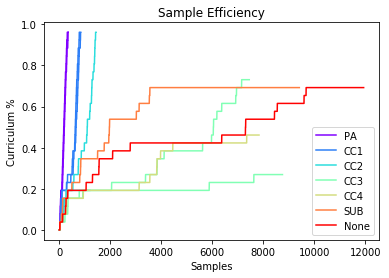

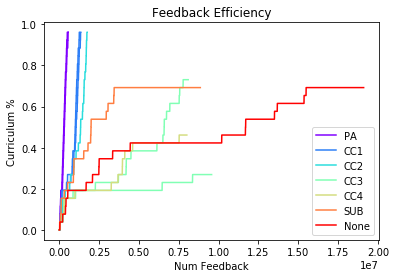

In [78]:
# Original Discount
# data_names = [
#     (444, 'PA'),
#     (445, 'CC1'),
#     (446, 'CC2'),
# #     (391, 'CC3'),
#     (447, 'SUB'),
#     (443, 'None'),
# ]

data_names = [
    ([477, 510], 'PA'),
    ([478, 511], 'CC1'),
    ([479, 535], 'CC2'),
    ([486, 505], 'CC3'),
    ([487], 'CC4'),
    ([480], 'SUB'),
    ([481], 'None'),
]

plot_curriculum(data_names, 'samples')

plot_curriculum(data_names, 'feedback')

# Claim 1: all forms of feedback help the agent learn a policy which does NOT require feedback than no teacher

This should be true, so long as the agent actually completes the curriculum, since the version w/o teacher does not.

If this isn't true for certain higher-level teachers that's fine, so long as we are able to show that the problem is grounding, but once grounded it does work better.

### GOOD NEWS: All agents trained with feedback outperform no teacher.

### BAD NEWS: Agents trained with complex teachers have a hard time completing the curriculum.

Although interestingly, CC2 and Subgoal beat the level where they got stuck when trained with no teacher! Seems like the self-distillation process actually helped the policy.

couldn't plot CC1


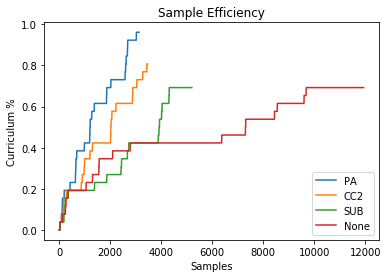

couldn't plot CC1


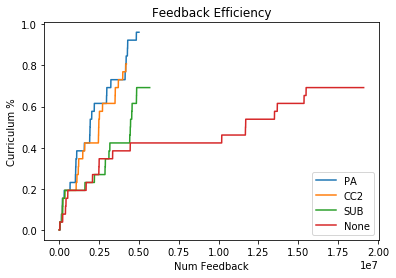

In [16]:
# original discount
# data_names = [
#     (437, 'PA'),
#     (452, 'CC1'),
#     (453, 'CC2'),
#     (454, 'SUB'),
#     (443, 'None'),
# ]


data_names = [
    (482, 'PA'),
    (483, 'CC1'),
    (484, 'CC2'),
    (485, 'SUB'),
    (481, 'None'),
]
plot_curriculum(data_names, 'samples')

plot_curriculum(data_names, 'feedback')

# Claim 2: Policies conditioned on feedback can generalize zero-shot (or few-shot) to performing new tasks with the teacher.
(The new levels should not have any new feedback vocabulary.)

### GOOD NEWS: all the teachers outperform not having a teacher
### BAD NEWS: the higher-level teachers are way worse than the easy teacher... we should find a way to learn those better.


In [11]:
def plot_final_generalization(runs, title):
    legend_list = []
    env_names = None
    env_dict = {}
    for run_name, legend_name in runs:
        for data_dir in data_dirs:
            for exp_dir in data_dir.iterdir():
                if run_name in exp_dir.name:
                    data = pd.read_csv(exp_dir.joinpath('results.csv'))
                    if env_names is None:
                        env_names = data[' env'].to_numpy()
                        env_dict = {env_name: [] for env_name in env_names}
                    success = data['success_rate'].to_numpy()
                    for i, (env_name, env_list) in enumerate(env_dict.items()):
                        env_list.append(success[i].item())
                    legend_list.append(legend_name)
    for env_name, env_list in env_dict.items():
        plt.title(title + ' - ' + env_name)
        plt.bar(legend_list, env_list)
        plt.show()
                    


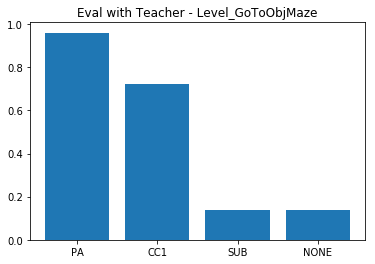

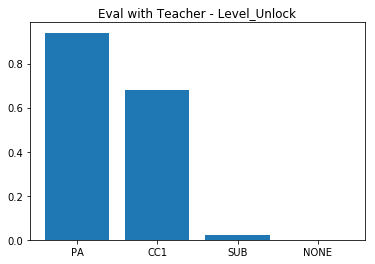

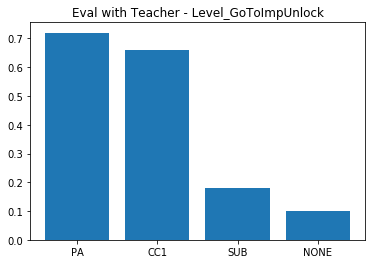

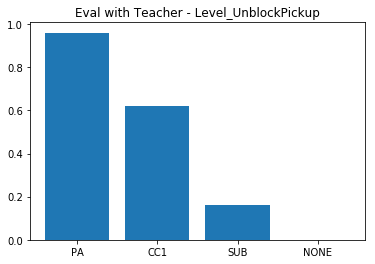

In [12]:
runs = [
    ('PA_nodistill', 'PA'),
    ('CC1_nodistill', 'CC1'),
    ('SUB_nodistill', 'SUB'),
    ('NONE_nodistill', 'NONE'),
]

plot_final_generalization(runs, 'Eval with Teacher')

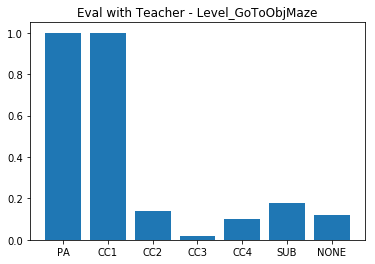

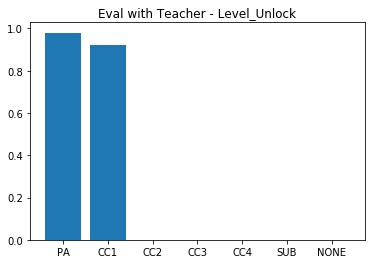

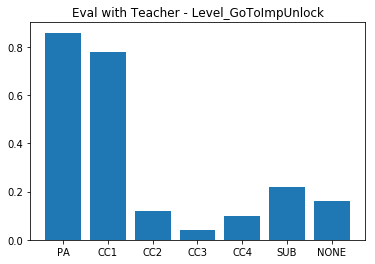

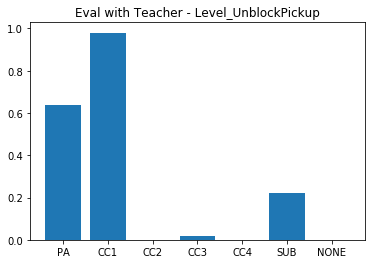

In [15]:
runs = [
    ('EVAL_PA_LOWD', 'PA'),
    ('EVAL_CC1_LOWD', 'CC1'),
    ('EVAL_CC2_LOWD', 'CC2'),
    ('EVAL_CC3_LOWD', 'CC3'),
    ('EVAL_CC4_LOWD', 'CC4'),
    ('EVAL_SUB_LOWD', 'SUB'),
    ('EVAL_NONE_LOWD', 'NONE'),
]

plot_final_generalization(runs, 'Eval with Teacher')

# Claim 3: With the distillation process, we can generalize to performing new tasks without using the reward. This process is more feedback-efficient than just providing rewards.

TODO!

# Claim 4: Lower-level communication is more sample-efficient + feedback-efficient to ground than higher-level.

The goal is to motivate why we want to bootstrap rather than using the higher-level teachers directly.

TODO

This is true from what we've seen so far. We could probably show this in a graph by training an agent (either on the start of the curriculum or on a certain level), and checking periodically whether it can solve the held-out levels. The easy teachers should be able to do this more quickly than the harder teachers.

# Claim 5: Higher level communication is most feedback-efficient on new levels once grounded.

The goal is to motivate why we want higher-level teachers at all.

It's definitly not true so far, since the agent isn't learning to follow the higher-level teachers very accurately. We should find a way to fix this.

TODO

# Claim 6: We can ground higher-level feedback using lower-level feedback and minimal use of the reward. This is more efficient than grounding the higher-level communication directly.

Goal is to show that bootstrapping is a reasonable thing to do.

May also help with grounding harder teachers better.

TODO

# Leaderboard - Curriculum Learning

Keep track of the current best methods of learning a curriculum (ranked by feedback-efficiency).

['437 - Distill from PA, Default'] [6289600.0]


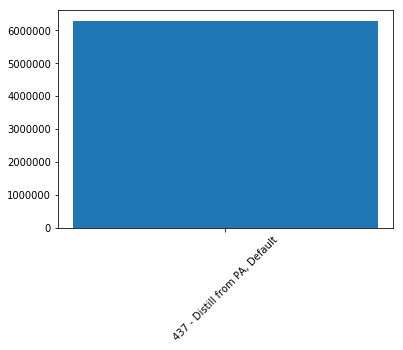

In [7]:
methods = [
    (437, "Distill from PA, Default", "Standard HParams, train PA, distill to powerset"), # TODO: placeholder; hasn't actually succeeded yet
]

plot_values = []
plot_names = []
for run_name, legend_name, _ in methods:
    try:
        data = load_data(run_name)
        num_feedback_key = 'Train/NumFeedbackTotal'
        num_feedback = np.mean([df[num_feedback_key].to_numpy()[-1].item() for df in data])
        plot_values.append(num_feedback)
        plot_names.append(f'{run_name} - {legend_name}')
    except:
        print("couldn't plot " + legend_name)
print(plot_names, plot_values)
plt.bar(plot_names, plot_values)
plt.xticks(rotation=45)
plt.show()


# Leaderboard - Few-Shot Generalization


Keep track of the current best methods of few-shot learning heldout levels (ranked by feedback-efficiency).

TODO